In [1]:
# from google.colab import drive
# drive.mount('/gdrive')
# %cd /gdrive/My Drive/[2024-2025] AN2DL/Lecture 5

In [2]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_cv

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import requests
from io import BytesIO
# import cv2
# from PIL import Image
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

import albumentations as A

2.16.1


In [3]:
data = np.load('/kaggle/input/an2dl-homework-2/mars_for_students.npz')
train_data = data['training_set']
submission_data = data['test_set']

targets = ['Background', 'Soil', 'Bedrock', 'Sand', 'Big Rock']
NUM_CLASSES = len(targets)
train_data.shape, submission_data.shape

((2615, 2, 64, 128), (10022, 64, 128))

## Search for duplicates (outliers)

In [4]:
ALIEN = train_data[2242,1]
count = 0

ALIENS = []

for i, image in enumerate(train_data[:,1]):
    if np.all(image == ALIEN):
        ALIENS.append(i)
        count += 1
print(ALIENS)

[62, 79, 125, 139, 142, 147, 152, 156, 170, 210, 217, 266, 289, 299, 313, 339, 348, 365, 412, 417, 426, 450, 461, 536, 552, 669, 675, 741, 744, 747, 799, 802, 808, 820, 821, 849, 863, 890, 909, 942, 971, 1005, 1057, 1079, 1082, 1092, 1095, 1106, 1119, 1125, 1177, 1194, 1224, 1247, 1248, 1258, 1261, 1262, 1306, 1324, 1365, 1370, 1443, 1449, 1508, 1509, 1519, 1551, 1584, 1588, 1628, 1637, 1693, 1736, 1767, 1768, 1782, 1813, 1816, 1834, 1889, 1925, 1942, 1975, 1979, 2000, 2002, 2086, 2096, 2110, 2111, 2151, 2161, 2222, 2235, 2239, 2242, 2301, 2307, 2350, 2361, 2365, 2372, 2414, 2453, 2522, 2535, 2561, 2609, 2614]


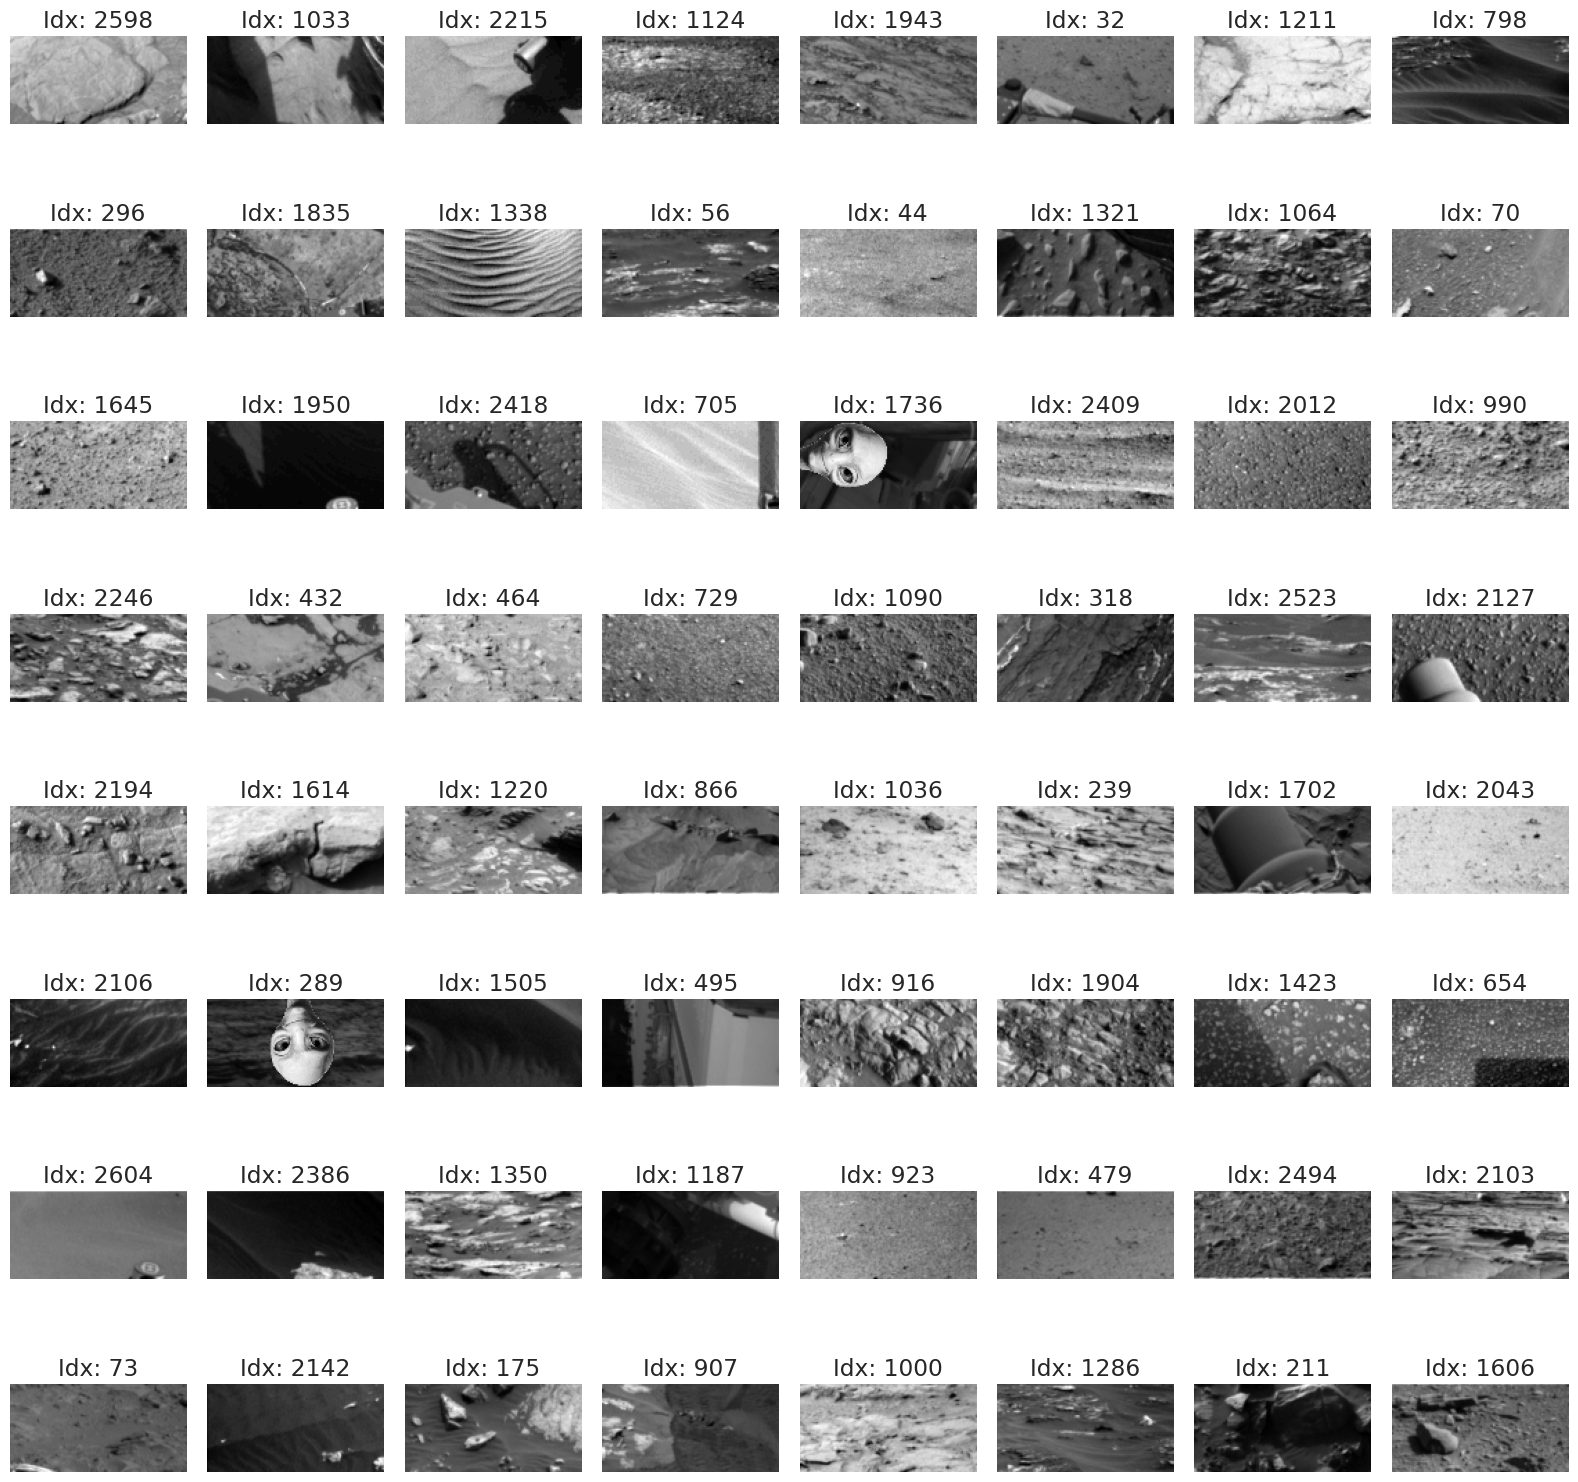

In [5]:
def display_random_image_block(data, indices = [],start=0, block_size=64):
    # Get random indices for 64 images
    indices = np.random.choice(data.shape[0], block_size, replace=False)
    # indices = np.arange(start, start+block_size)
    
    # Extract the images (first channel)
    images = data[indices, 0, :, :]
    
    # Set up a grid of 8x8 for displaying 64 images
    fig, axes = plt.subplots(8, 8, figsize=(16, 16))
    axes = axes.ravel()
    
    for i, idx in enumerate(indices[:block_size]):
        ax = axes[i]
        ax.imshow(images[i], cmap='gray')  # Display the image in grayscale
        ax.set_title(f"Idx: {idx}")  # Display the index as the title
        ax.axis('off')  # Turn off axis labels
    
    plt.tight_layout()
    plt.show()

# Example usage with a dataset of shape (2615, 2, 64, 128)
display_random_image_block(train_data, indices=ALIENS[:64])


In [6]:
X_removed = np.delete(train_data, ALIENS, axis=0)
train_data.shape, X_removed.shape, len(ALIENS)

((2615, 2, 64, 128), (2505, 2, 64, 128), 110)

In [7]:
X_train, X_val = train_test_split(X_removed, train_size=0.8, shuffle=True)
X_val, X_test = train_test_split(X_val, train_size=0.5, shuffle=True)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (2004, 2, 64, 128)
X_val shape: (250, 2, 64, 128)
X_test shape: (251, 2, 64, 128)


## Visualize train data

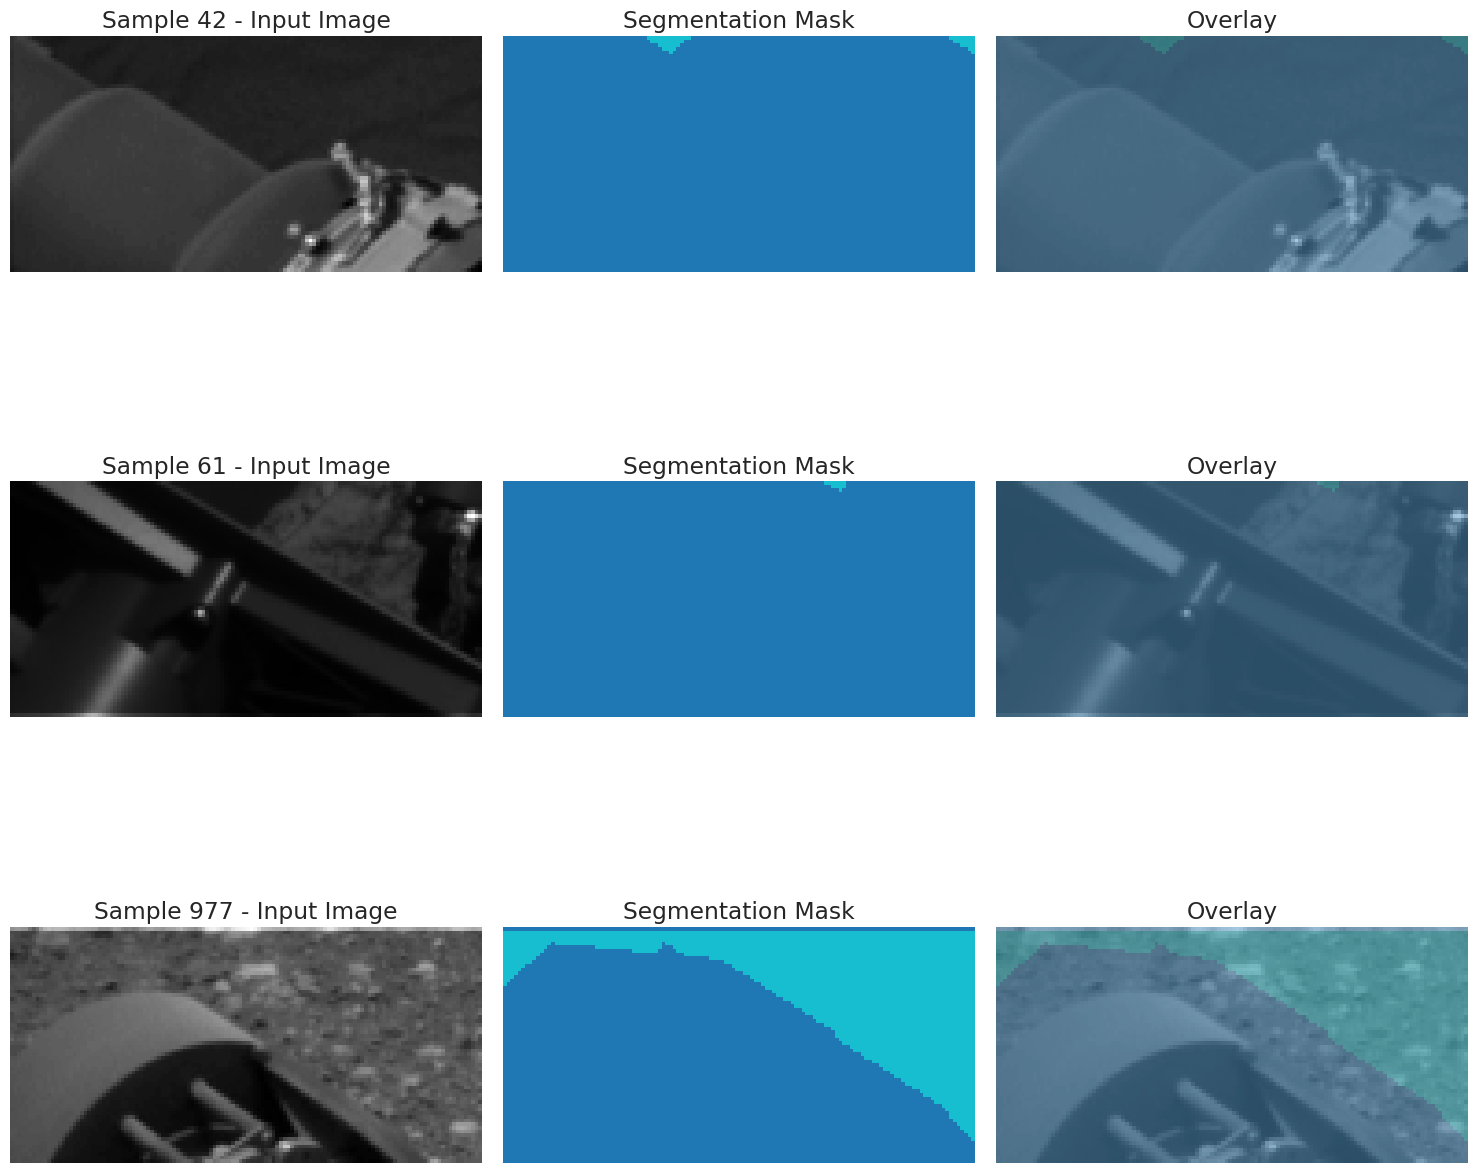

In [8]:
def visualize_samples(input_images, indices):
    fig, axes = plt.subplots(len(indices), 3, figsize=(15, 5 * len(indices)))

    for i, index in enumerate(indices):
        input_image = input_images[index, 0]
        segmentation_mask = input_images[index, 1]

        # Input image
        axes[i, 0].imshow(input_image, cmap='gray')
        axes[i, 0].set_title(f"Sample {index} - Input Image")
        axes[i, 0].axis("off")

        # Segmentation mask
        axes[i, 1].imshow(segmentation_mask, cmap='tab10')
        axes[i, 1].set_title("Segmentation Mask")
        axes[i, 1].axis("off")

        # Overlay
        axes[i, 2].imshow(input_image, cmap='gray', alpha=0.8)
        axes[i, 2].imshow(segmentation_mask, cmap='tab10', alpha=0.4)
        axes[i, 2].set_title("Overlay")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

indices = np.random.randint(0, len(X_removed), 0)
indices = np.append(indices,[42, 61, 977])

visualize_samples(X_removed, indices=indices)

## Visualize submisison data

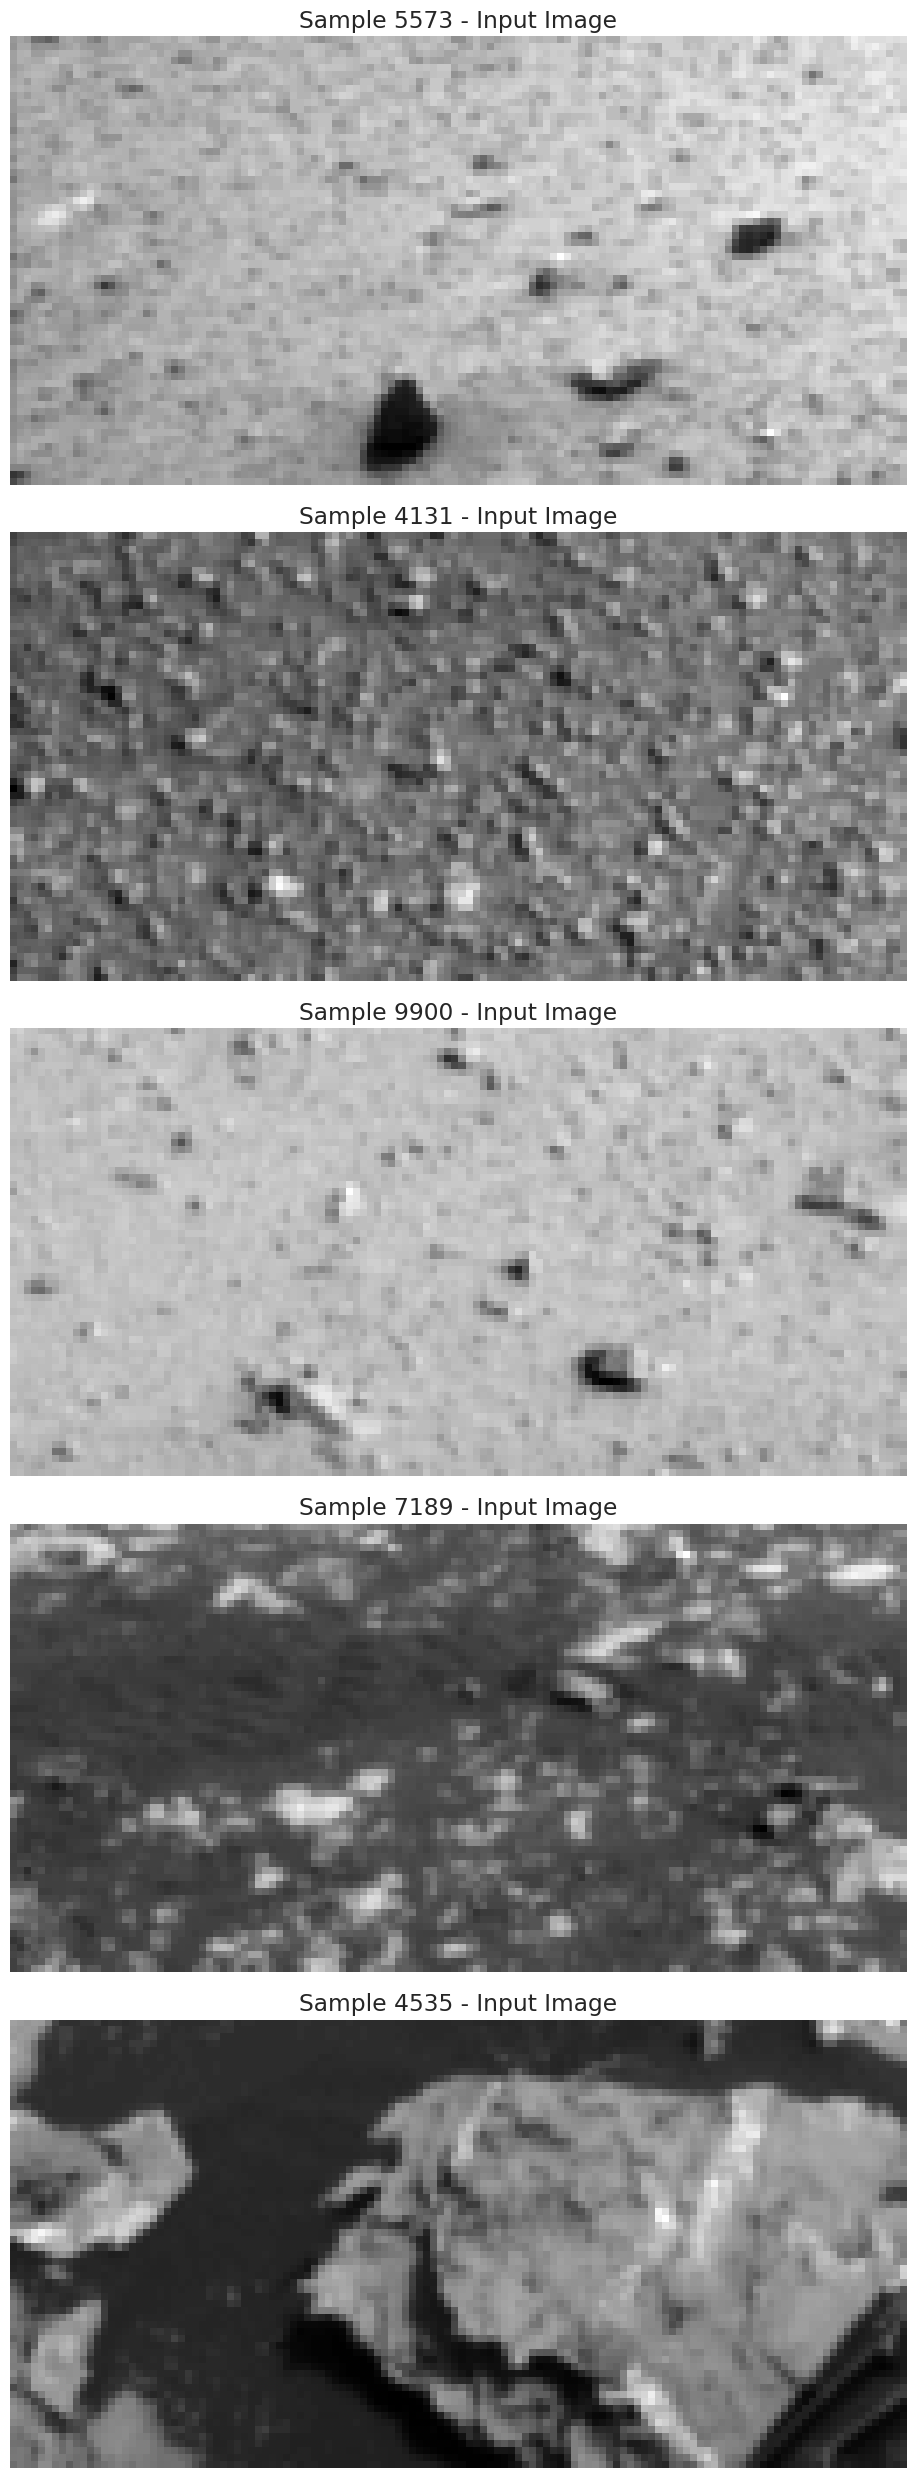

In [9]:
def visualize_samples(input_images, indices):
    fig, axes = plt.subplots(len(indices), 1, figsize=(15, 5 * len(indices)))

    for i, index in enumerate(indices):
        input_image = input_images[index]

        # Input image
        axes[i].imshow(input_image, cmap='gray')
        axes[i].set_title(f"Sample {index} - Input Image")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

indices = np.random.randint(0, len(submission_data), 5)

visualize_samples(submission_data, indices=indices)

## Augment the training set

In [10]:
def augment(X):
    augmentation_pipeline_base = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.5),
        A.Resize(height=64, width=128),  # Enforce consistent dimensions
    ], additional_targets={"mask": "mask"})
    
    augmentation_pipeline_advanced = A.Compose([
        A.RandomGridShuffle(grid = (2,3), p=0.5),
        A.GridDropout(ratio=0.2, mask_fill_value=0, random_offset=True, p=0.5),
        A.ElasticTransform(alpha=1, sigma=50, p=0.2),
        A.GridDistortion(p=0.2),
    ], additional_targets={"mask": "mask"})
    
    X_augmented_base = []
    for i in range(4):
        # Now X_augmented will have both the augmented image and mask
        X_augmented = []
        
        for sample in X:
            augmented_sample = augmentation_pipeline_base(image = sample[0], mask = sample[1])
            augmented_sample_np = np.stack([augmented_sample['image'].squeeze(), augmented_sample['mask']], axis=0)
            X_augmented.append(augmented_sample_np)
        X_augmented = np.array(X_augmented)
        X_augmented_base.append(X_augmented)
        #X_augmented.shape
    
    X_augmented_base = np.concatenate(X_augmented_base, axis=0)
    X_augmented_base = np.concatenate((X, X, X_augmented_base), axis=0)
    
    X_augmented_advanced = []
    for i in range(3):
        # Now X_augmented will have both the augmented image and mask
        X_augmented = []
        
        for sample in X_augmented_base:
            augmented_sample = augmentation_pipeline_advanced(image = sample[0], mask = sample[1])
            augmented_sample_np = np.stack([augmented_sample['image'].squeeze(), augmented_sample['mask']], axis=0)
            X_augmented.append(augmented_sample_np)
        
        X_augmented = np.array(X_augmented)
        X_augmented_advanced.append(X_augmented)
        #X_augmented.shape
    
    X_augmented_advanced = np.concatenate(X_augmented_advanced, axis=0)
    X_augmented_advanced = np.concatenate((X, X_augmented_base, X_augmented_advanced), axis=0)

    return X_augmented_advanced

X_train_augmented_advanced = augment(X_train)
X_train_augmented_advanced.shape

(50100, 2, 64, 128)

## Augment the validation set

In [11]:
X_val_augmented_advanced=augment(X_val)

X_val_augmented_advanced.shape

(6250, 2, 64, 128)

## Augment the test set

In [12]:
X_test_augmented_advanced=augment(X_test)

X_test_augmented_advanced.shape

(6275, 2, 64, 128)

## Visualize augmentation

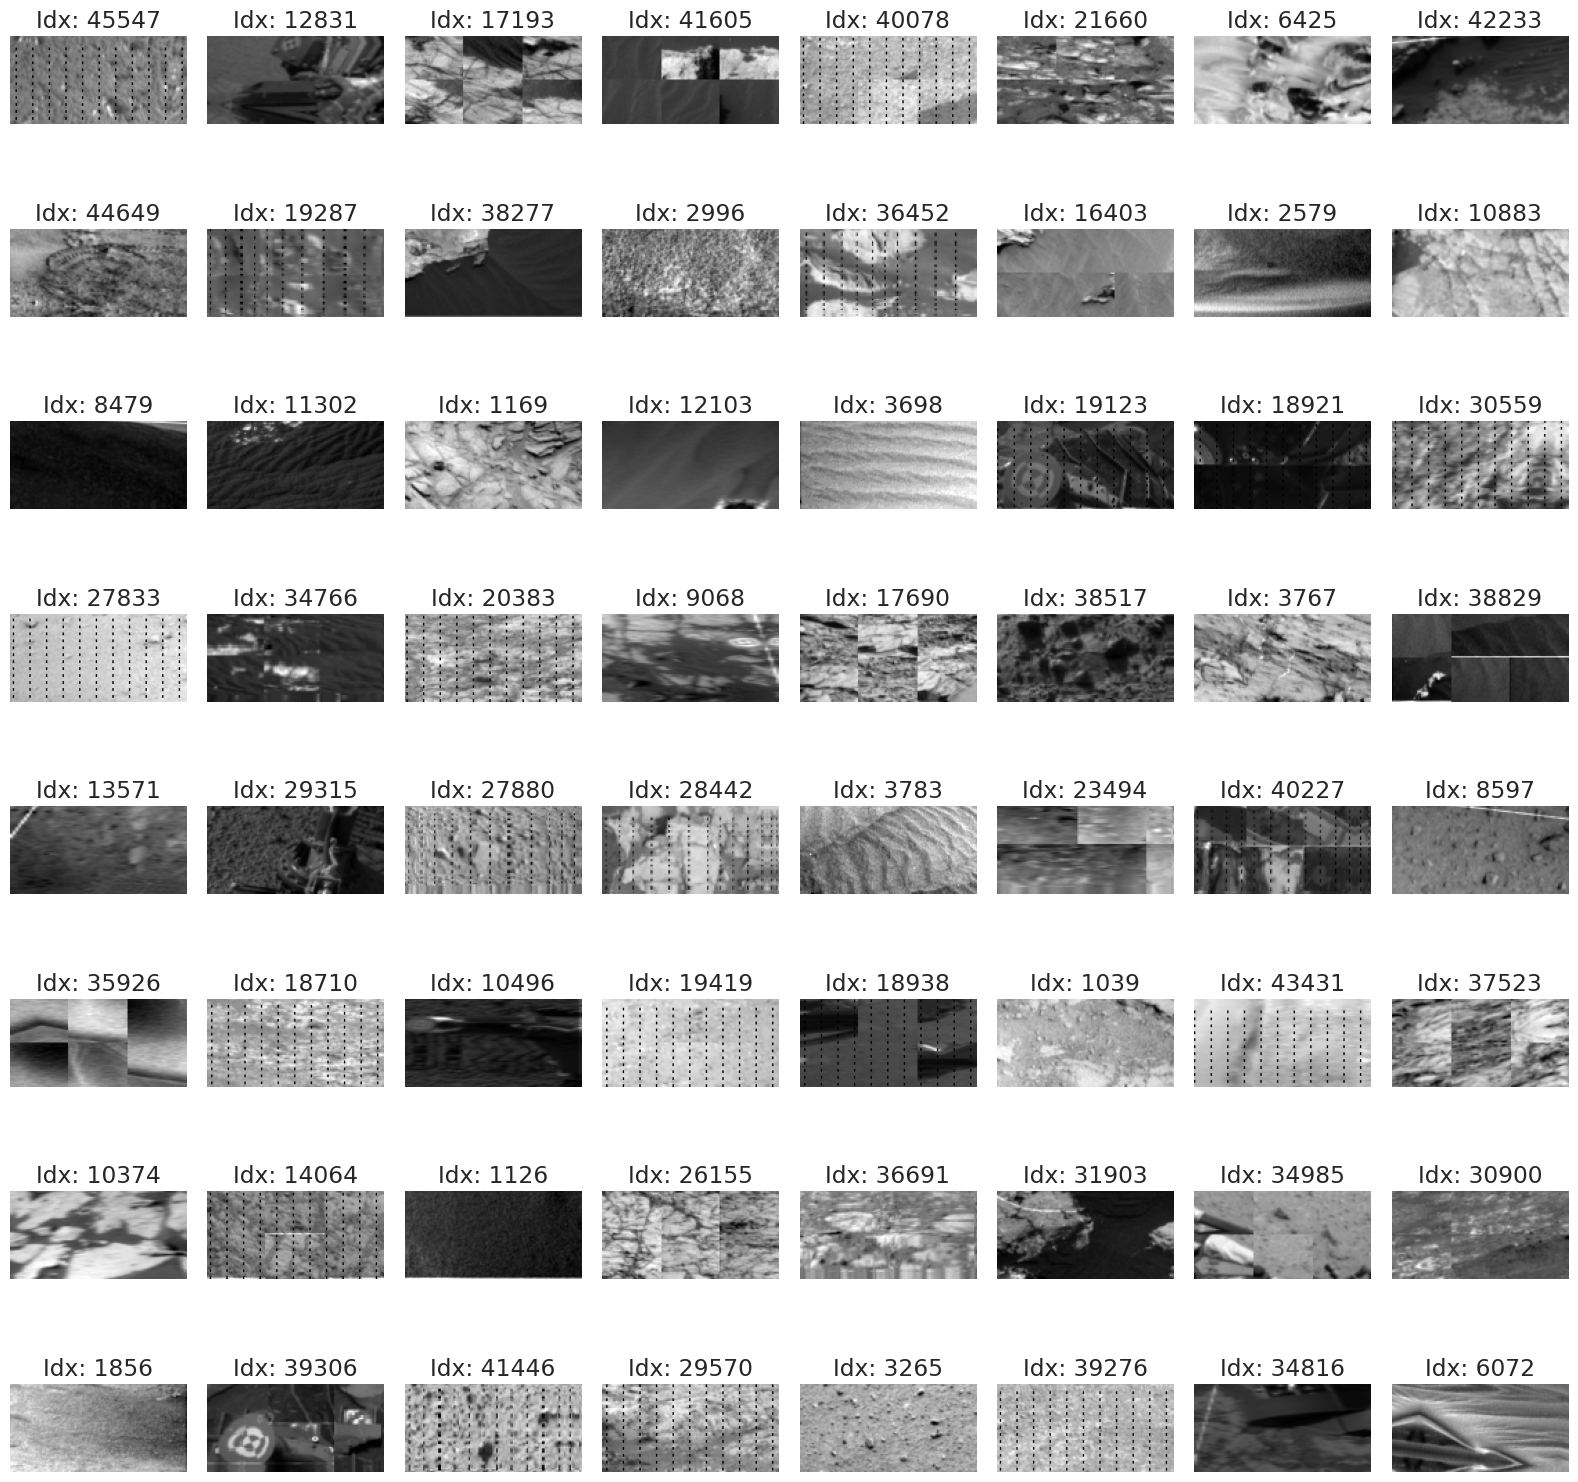

In [13]:
display_random_image_block(X_train_augmented_advanced)

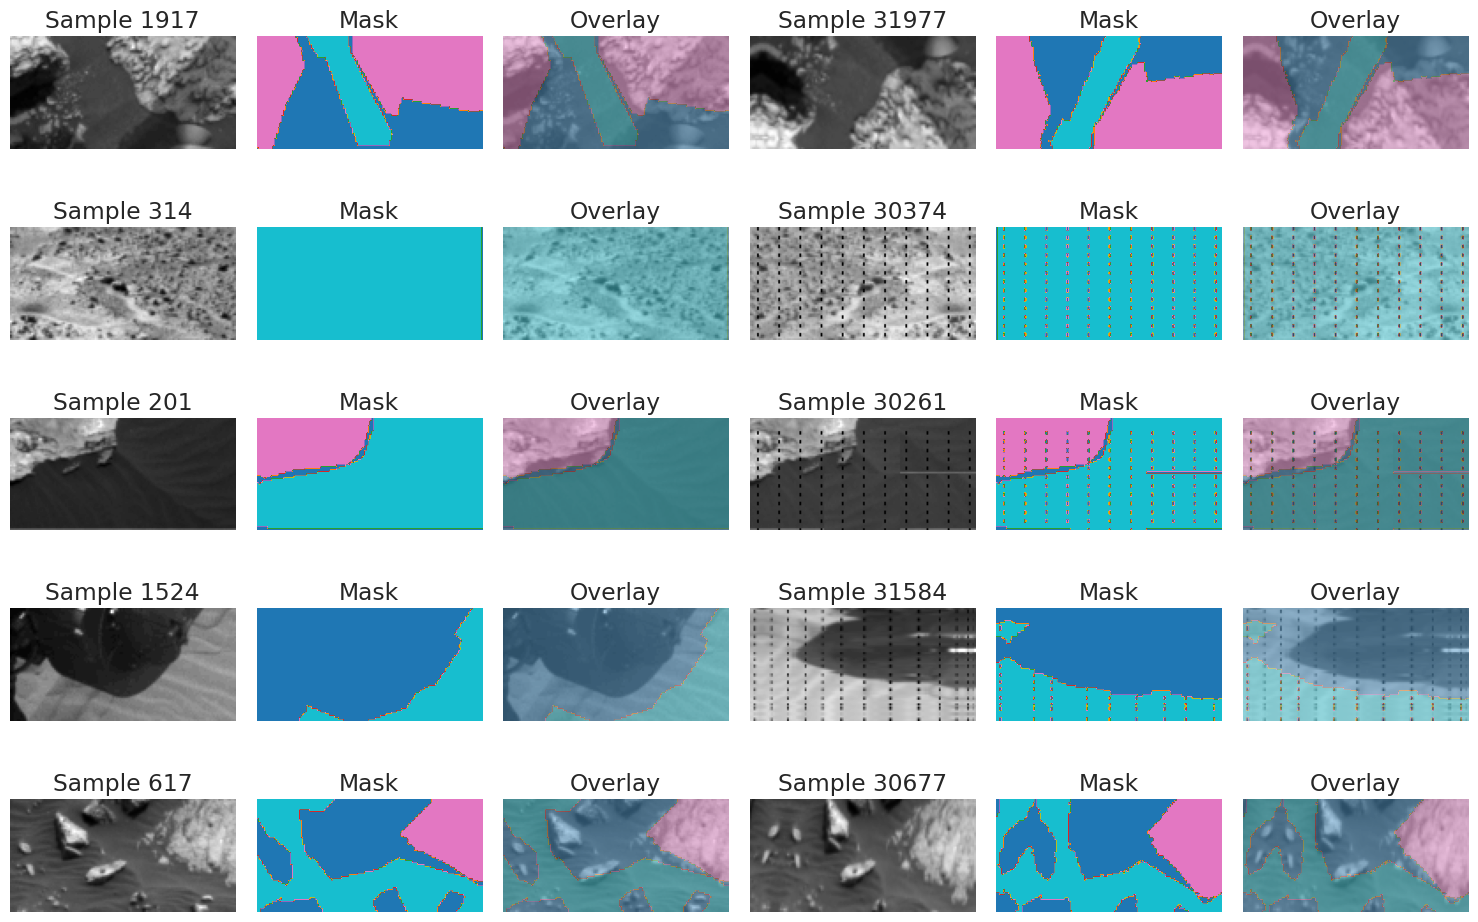

In [14]:
def visualize_augmented_samples(input_images, augmented_images, indices):
    fig, axes = plt.subplots(len(indices), 6, figsize=(15, 2 * len(indices)))

    for i, index in enumerate(indices):
        shift = len(input_images)*15
        
        input_image = input_images[index, 0]
        augmented_image = augmented_images[index+shift, 0]
        segmentation_mask = input_images[index, 1]
        augmented_mask = augmented_images[index+shift, 1]

        # Input image
        axes[i, 0].imshow(input_image, cmap='gray')
        axes[i, 0].set_title(f"Sample {index}")
        axes[i, 0].axis("off")

        # Segmentation mask
        axes[i, 1].imshow(segmentation_mask, cmap='tab10')
        axes[i, 1].set_title("Mask")
        axes[i, 1].axis("off")

        # Overlay
        axes[i, 2].imshow(input_image, cmap='gray', alpha=0.8)
        axes[i, 2].imshow(segmentation_mask, cmap='tab10', alpha=0.4)
        axes[i, 2].set_title("Overlay")
        axes[i, 2].axis("off")        
        
        # Input image
        axes[i, 3].imshow(augmented_image, cmap='gray')
        axes[i, 3].set_title(f"Sample {index+shift}")
        axes[i, 3].axis("off")

        # Segmentation mask
        axes[i, 4].imshow(augmented_mask, cmap='tab10')
        axes[i, 4].set_title("Mask")
        axes[i, 4].axis("off")

        # Overlay
        axes[i, 5].imshow(augmented_image, cmap='gray', alpha=0.8)
        axes[i, 5].imshow(augmented_mask, cmap='tab10', alpha=0.4)
        axes[i, 5].set_title("Overlay")
        axes[i, 5].axis("off")

    plt.tight_layout()
    plt.show()

indices = np.random.randint(0, len(X_train), 5)

visualize_augmented_samples(X_train, X_train_augmented_advanced, indices=indices)

## Change type to save space

In [15]:
np.savez(
    'augmented_dataset',
    X_train = X_train_augmented_advanced.astype(np.uint8),
    X_val = X_val_augmented_advanced.astype(np.uint8),
    X_test = X_test_augmented_advanced.astype(np.uint8),
    X_to_predict = submission_data.astype(np.uint8),
)